## Binary Classification of Madelon

Download datasets

In [79]:
import torch
torch.manual_seed(0)

In [80]:
import openml as oml
import pandas as pd
madelon_dataset = oml.datasets.get_dataset(1485)
X, y, categorical_indicator, attribute_names = madelon_dataset.get_data(
target=madelon_dataset.default_target_attribute, dataset_format='dataframe')
print(f'Madelon dataset X: {X.shape}, y: {y.shape}')
X_np = X.to_numpy()
X_np = X_np/999
y_np = y.factorize()[0]

Madelon dataset X: (2600, 500), y: (2600,)


Start with 1 server and 1 clients.

In [81]:
client_id_list = [0]

The __Courier__ class is in charge of transmiting message between clients and server. Since we'are doing local simulation, a synchronized local courier is enough

In [82]:
from Courier import SyncLocalCourier
courier = SyncLocalCourier(client_id_list)

We also need a dataloader. The __DataLoader__ class distributes the data to each clients based on thier id.
Since the data source is numpy arrays, we use __SimpleNumpyDataLoader__ here

In [83]:
from VFLDataUtils import SimpleNumpyDataLoader
loader = SimpleNumpyDataLoader(
    clients_id_list=client_id_list,
    data_source=(X_np, y_np), dim_split=[250]
)

__dim_split__ here is a list contains the split points.
The length of __dim_split__ should be the same as the number of clients in clients list. Features remained is used as server's feature

In [84]:
loader_dict = loader.distribute()

Client 0: Feature Index 0-250
Server : Feature Index 250-500


loader.distribute() will return a dictionary whose keys are clients'id, and valuese are the corresponding train, test loaders.

In [85]:
print(loader_dict)

{0: {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x000002778158CE50>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x00000277815AA7F0>}, 'server': {'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x00000277815AA4C0>, 'test_loader': <torch.utils.data.dataloader.DataLoader object at 0x00000277815AA850>}}


Now we create client's neural models

In [86]:
from torch import nn
client_model = nn.Sequential(
    nn.Linear(250, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU()
)

Declare a Synchronized local clients. simple_config.ini records hyper parameters 

In [87]:
from Client import SyncFNNClient
client = SyncFNNClient(id=0, 
    model=client_model,
    courier=courier,
    train_loader=loader_dict[0]['train_loader'],
    test_loader=loader_dict[0]['test_loader'],
    config_dir='simple_config.ini'
)
clients = [client]

Strategy is used for server to control clients' behaviour

In [88]:
from Strategy import SyncConcatStrategy
strategy = SyncConcatStrategy(
    courier=courier,
    clients=clients
)

Now we create models of server. Server should have two models, one is to generate embedding from a partition of the features and the other one is to combine all embedding from clients 

In [89]:
server_emb_model = nn.Sequential(
    nn.Linear(250, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU()
)
server_top_model = nn.Sequential(
    nn.Linear(2*32, 32),
    nn.ReLU(True),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

In [90]:
from Server import SyncFNNServer
server = SyncFNNServer(
    strategy=strategy,
    courier=courier,
    top_model=server_top_model,
    emb_model=server_emb_model,
    train_loader=loader_dict['server']['train_loader'],
    test_loader=loader_dict['server']['test_loader'],
    config_dir='simple_config.ini'
)

Let's start training

In [91]:
print('Training Starts')
print('-'*89)
for epoch in range(600):
    server.fit(epoch)

Training Starts
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69329 | Acc: 0.503 | Val ACC: 0.506
Epoch 001: | Loss: 0.69317 | Acc: 0.503 | Val ACC: 0.506
Epoch 002: | Loss: 0.69315 | Acc: 0.503 | Val ACC: 0.506
Epoch 003: | Loss: 0.69315 | Acc: 0.503 | Val ACC: 0.506
Epoch 004: | Loss: 0.69314 | Acc: 0.503 | Val ACC: 0.506
Epoch 005: | Loss: 0.69314 | Acc: 0.503 | Val ACC: 0.506
Epoch 006: | Loss: 0.69313 | Acc: 0.503 | Val ACC: 0.506
Epoch 007: | Loss: 0.69313 | Acc: 0.503 | Val ACC: 0.506
Epoch 008: | Loss: 0.69312 | Acc: 0.503 | Val ACC: 0.506
Epoch 009: | Loss: 0.69312 | Acc: 0.503 | Val ACC: 0.506
Epoch 010: | Loss: 0.69311 | Acc: 0.503 | Val ACC: 0.506
Epoch 011: | Loss: 0.69310 | Acc: 0.503 | Val ACC: 0.506
Epoch 012: | Loss: 0.69310 | Acc: 0.503 | Val ACC: 0.506
Epoch 013: | Loss: 0.69309 | Acc: 0.503 | Val ACC: 0.506
Epoch 014: | Loss: 0.69308 | Acc: 0.503 | Val ACC: 0.506
Epoch 015: | Loss: 0.69307 | Acc: 0.503

In [92]:
history1 = server.get_history()
history1.tail()

,train-acc,test-acc
595,0.758272,0.696154
596,0.767463,0.698077
597,0.768842,0.690385
598,0.765165,0.671154
599,0.765625,0.678846


How's the performance when we have more clients? 

In [93]:
client_id_list = list(range(2))
courier = SyncLocalCourier(client_id_list)
loader = SimpleNumpyDataLoader(
    clients_id_list=client_id_list,
    data_source=(X_np, y_np)
)
loader_dict = loader.distribute()

Client 0: Feature Index 0-166
Client 1: Feature Index 167-333
Server : Feature Index 334-499


In [95]:
clients = [
    SyncFNNClient(id=id, 
    model=nn.Sequential(
        nn.Linear(167, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    courier=courier,
    train_loader=loader_dict[id]['train_loader'],
    test_loader=loader_dict[id]['test_loader'],
    config_dir='simple_config.ini')
for id in client_id_list]
strategy = SyncConcatStrategy(courier=courier, clients=clients)
server =  SyncFNNServer(
    strategy=strategy,
    courier=courier,
    top_model=nn.Sequential(
        nn.Linear(3 * 32, 32),
        nn.ReLU(True),
        nn.Linear(32, 1),
        nn.Sigmoid()),
    emb_model=nn.Sequential( 
        nn.Linear(166, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    train_loader=loader_dict['server']['train_loader'],
    test_loader=loader_dict['server']['test_loader'],
    config_dir='simple_config.ini')

In [96]:
print('Training Starts')
print('-'*89)
for epoch in range(600):
    server.fit(epoch)

Training Starts
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69339 | Acc: 0.503 | Val ACC: 0.506
Epoch 001: | Loss: 0.69319 | Acc: 0.503 | Val ACC: 0.506
Epoch 002: | Loss: 0.69318 | Acc: 0.503 | Val ACC: 0.506
Epoch 003: | Loss: 0.69315 | Acc: 0.503 | Val ACC: 0.506
Epoch 004: | Loss: 0.69312 | Acc: 0.503 | Val ACC: 0.506
Epoch 005: | Loss: 0.69309 | Acc: 0.503 | Val ACC: 0.506
Epoch 006: | Loss: 0.69306 | Acc: 0.503 | Val ACC: 0.506
Epoch 007: | Loss: 0.69302 | Acc: 0.502 | Val ACC: 0.506
Epoch 008: | Loss: 0.69298 | Acc: 0.505 | Val ACC: 0.504
Epoch 009: | Loss: 0.69292 | Acc: 0.504 | Val ACC: 0.521
Epoch 010: | Loss: 0.69284 | Acc: 0.516 | Val ACC: 0.556
Epoch 011: | Loss: 0.69273 | Acc: 0.523 | Val ACC: 0.575
Epoch 012: | Loss: 0.69259 | Acc: 0.538 | Val ACC: 0.602
Epoch 013: | Loss: 0.69242 | Acc: 0.541 | Val ACC: 0.615
Epoch 014: | Loss: 0.69216 | Acc: 0.531 | Val ACC: 0.615
Epoch 015: | Loss: 0.69193 | Acc: 0.529

In [97]:
history2 = server.get_history()

3 clients

In [98]:
client_id_list = list(range(3))
courier = SyncLocalCourier(client_id_list)
loader = SimpleNumpyDataLoader(
    clients_id_list=client_id_list,
    data_source=(X_np, y_np)
)
loader_dict = loader.distribute()

Client 0: Feature Index 0-124
Client 1: Feature Index 125-249
Client 2: Feature Index 250-374
Server : Feature Index 375-499


In [99]:
clients = [
    SyncFNNClient(id=id, 
    model=nn.Sequential(
        nn.Linear(125, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    courier=courier,
    train_loader=loader_dict[id]['train_loader'],
    test_loader=loader_dict[id]['test_loader'],
    config_dir='simple_config.ini')
for id in client_id_list]
strategy = SyncConcatStrategy(courier=courier, clients=clients)
server =  SyncFNNServer(
    strategy=strategy,
    courier=courier,
    top_model=nn.Sequential(
        nn.Linear(4 * 32, 32),
        nn.ReLU(True),
        nn.Linear(32, 1),
        nn.Sigmoid()),
    emb_model=nn.Sequential( 
        nn.Linear(125, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    train_loader=loader_dict['server']['train_loader'],
    test_loader=loader_dict['server']['test_loader'],
    config_dir='simple_config.ini')

print('Training Starts')
print('-'*89)
for epoch in range(600):
    server.fit(epoch)
history3 = server.get_history()
    

Training Starts
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69350 | Acc: 0.499 | Val ACC: 0.506
Epoch 001: | Loss: 0.69315 | Acc: 0.503 | Val ACC: 0.506
Epoch 002: | Loss: 0.69313 | Acc: 0.503 | Val ACC: 0.506
Epoch 003: | Loss: 0.69309 | Acc: 0.503 | Val ACC: 0.506
Epoch 004: | Loss: 0.69306 | Acc: 0.503 | Val ACC: 0.506
Epoch 005: | Loss: 0.69303 | Acc: 0.503 | Val ACC: 0.506
Epoch 006: | Loss: 0.69299 | Acc: 0.502 | Val ACC: 0.512
Epoch 007: | Loss: 0.69294 | Acc: 0.503 | Val ACC: 0.517
Epoch 008: | Loss: 0.69288 | Acc: 0.503 | Val ACC: 0.525
Epoch 009: | Loss: 0.69281 | Acc: 0.514 | Val ACC: 0.538
Epoch 010: | Loss: 0.69271 | Acc: 0.512 | Val ACC: 0.571
Epoch 011: | Loss: 0.69261 | Acc: 0.534 | Val ACC: 0.533
Epoch 012: | Loss: 0.69246 | Acc: 0.516 | Val ACC: 0.567
Epoch 013: | Loss: 0.69225 | Acc: 0.533 | Val ACC: 0.583
Epoch 014: | Loss: 0.69204 | Acc: 0.541 | Val ACC: 0.558
Epoch 015: | Loss: 0.69177 | Acc: 0.525

4 clients

In [100]:
client_id_list = list(range(4))
courier = SyncLocalCourier(client_id_list)
loader = SimpleNumpyDataLoader(
    clients_id_list=client_id_list,
    data_source=(X_np, y_np)
)
loader_dict = loader.distribute()

Client 0: Feature Index 0-99
Client 1: Feature Index 100-199
Client 2: Feature Index 200-299
Client 3: Feature Index 300-399
Server : Feature Index 400-499


In [101]:
clients = [
    SyncFNNClient(id=id, 
    model=nn.Sequential(
        nn.Linear(100, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    courier=courier,
    train_loader=loader_dict[id]['train_loader'],
    test_loader=loader_dict[id]['test_loader'],
    config_dir='simple_config.ini')
for id in client_id_list]
strategy = SyncConcatStrategy(courier=courier, clients=clients)
server =  SyncFNNServer(
    strategy=strategy,
    courier=courier,
    top_model=nn.Sequential(
        nn.Linear(5 * 32, 32),
        nn.ReLU(True),
        nn.Linear(32, 1),
        nn.Sigmoid()),
    emb_model=nn.Sequential( 
        nn.Linear(100, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    train_loader=loader_dict['server']['train_loader'],
    test_loader=loader_dict['server']['test_loader'],
    config_dir='simple_config.ini')

print('Training Starts')
print('-'*89)
for epoch in range(600):
    server.fit(epoch)
history4 = server.get_history()
    

Training Starts
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69368 | Acc: 0.478 | Val ACC: 0.492
Epoch 001: | Loss: 0.69321 | Acc: 0.506 | Val ACC: 0.506
Epoch 002: | Loss: 0.69315 | Acc: 0.503 | Val ACC: 0.506
Epoch 003: | Loss: 0.69312 | Acc: 0.504 | Val ACC: 0.506
Epoch 004: | Loss: 0.69310 | Acc: 0.503 | Val ACC: 0.506
Epoch 005: | Loss: 0.69306 | Acc: 0.503 | Val ACC: 0.506
Epoch 006: | Loss: 0.69303 | Acc: 0.503 | Val ACC: 0.523
Epoch 007: | Loss: 0.69299 | Acc: 0.513 | Val ACC: 0.515
Epoch 008: | Loss: 0.69293 | Acc: 0.503 | Val ACC: 0.523
Epoch 009: | Loss: 0.69286 | Acc: 0.507 | Val ACC: 0.552
Epoch 010: | Loss: 0.69278 | Acc: 0.517 | Val ACC: 0.565
Epoch 011: | Loss: 0.69265 | Acc: 0.519 | Val ACC: 0.560
Epoch 012: | Loss: 0.69253 | Acc: 0.549 | Val ACC: 0.563
Epoch 013: | Loss: 0.69235 | Acc: 0.543 | Val ACC: 0.558
Epoch 014: | Loss: 0.69214 | Acc: 0.532 | Val ACC: 0.554
Epoch 015: | Loss: 0.69183 | Acc: 0.550

9 clients

In [104]:
client_id_list = list(range(9))
courier = SyncLocalCourier(client_id_list)
loader = SimpleNumpyDataLoader(
    clients_id_list=client_id_list,
    data_source=(X_np, y_np)
)
loader_dict = loader.distribute()

Client 0: Feature Index 0-49
Client 1: Feature Index 50-99
Client 2: Feature Index 100-149
Client 3: Feature Index 150-199
Client 4: Feature Index 200-249
Client 5: Feature Index 250-299
Client 6: Feature Index 300-349
Client 7: Feature Index 350-399
Client 8: Feature Index 400-449
Server : Feature Index 450-499


In [105]:
clients = [
    SyncFNNClient(id=id, 
    model=nn.Sequential(
        nn.Linear(50, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    courier=courier,
    train_loader=loader_dict[id]['train_loader'],
    test_loader=loader_dict[id]['test_loader'],
    config_dir='simple_config.ini')
for id in client_id_list]
strategy = SyncConcatStrategy(courier=courier, clients=clients)
server =  SyncFNNServer(
    strategy=strategy,
    courier=courier,
    top_model=nn.Sequential(
        nn.Linear(10 * 32, 32),
        nn.ReLU(True),
        nn.Linear(32, 1),
        nn.Sigmoid()),
    emb_model=nn.Sequential( 
        nn.Linear(50, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU()),
    train_loader=loader_dict['server']['train_loader'],
    test_loader=loader_dict['server']['test_loader'],
    config_dir='simple_config.ini')

print('Training Starts')
print('-'*89)
for epoch in range(600):
    server.fit(epoch)
history5 = server.get_history()
    

Training Starts
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69343 | Acc: 0.496 | Val ACC: 0.494
Epoch 001: | Loss: 0.69309 | Acc: 0.504 | Val ACC: 0.508
Epoch 002: | Loss: 0.69298 | Acc: 0.502 | Val ACC: 0.512
Epoch 003: | Loss: 0.69289 | Acc: 0.514 | Val ACC: 0.558
Epoch 004: | Loss: 0.69280 | Acc: 0.521 | Val ACC: 0.548
Epoch 005: | Loss: 0.69267 | Acc: 0.511 | Val ACC: 0.579
Epoch 006: | Loss: 0.69252 | Acc: 0.528 | Val ACC: 0.579
Epoch 007: | Loss: 0.69231 | Acc: 0.543 | Val ACC: 0.590
Epoch 008: | Loss: 0.69209 | Acc: 0.555 | Val ACC: 0.538
Epoch 009: | Loss: 0.69175 | Acc: 0.544 | Val ACC: 0.577
Epoch 010: | Loss: 0.69131 | Acc: 0.554 | Val ACC: 0.583
Epoch 011: | Loss: 0.69080 | Acc: 0.553 | Val ACC: 0.560
Epoch 012: | Loss: 0.69012 | Acc: 0.558 | Val ACC: 0.554
Epoch 013: | Loss: 0.68931 | Acc: 0.562 | Val ACC: 0.594
Epoch 014: | Loss: 0.68811 | Acc: 0.574 | Val ACC: 0.558
Epoch 015: | Loss: 0.68696 | Acc: 0.560

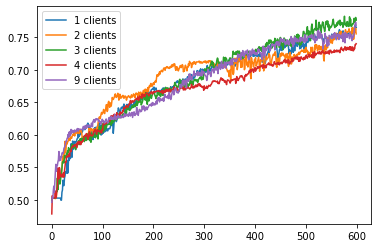

In [106]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(600), history1['train-acc'], label='1 clients')
plt.plot(np.arange(600), history2['train-acc'], label='2 clients')
plt.plot(np.arange(600), history3['train-acc'], label='3 clients')
plt.plot(np.arange(600), history4['train-acc'], label='4 clients')
plt.plot(np.arange(600), history5['train-acc'], label='9 clients')
plt.legend()


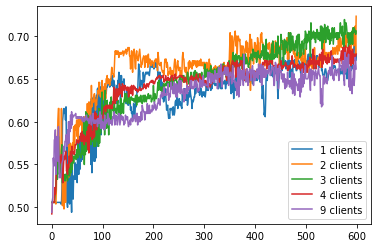

In [107]:
plt.plot(np.arange(600), history1['test-acc'], label='1 clients')
plt.plot(np.arange(600), history2['test-acc'], label='2 clients')
plt.plot(np.arange(600), history3['test-acc'], label='3 clients')
plt.plot(np.arange(600), history4['test-acc'], label='4 clients')
plt.plot(np.arange(600), history5['test-acc'], label='9 clients')
plt.legend()
